In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.collections as mpc

import calendar
import pytz

from plotly.subplots import make_subplots
from datetime import datetime, time, date, timedelta
from statsmodels.tsa.seasonal import STL
from scipy.stats import gaussian_kde, spearmanr
from scipy.integrate import quad
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sktime.transformations.series.detrend import STLTransformer
from sktime.utils.plotting import plot_series
from statsmodels.tsa.seasonal import STL

plt.style.use('ggplot')

In [30]:
def plot_candlestick(df, anomaly, title):
    
    # fig = go.Figure()
    fig = make_subplots(specs=[[{'secondary_y': True}]])
    
    fig.add_trace(
        go.Candlestick(
            x=df['datetime'],
            open=df['open'],
            low=df['low'],
            high=df['high'],
            close=df['close'],
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Bar(
            x=df['datetime'],
            y=df['volume'],
            opacity=0.5,
            showlegend=False,
            name='Volume'
        ),
        secondary_y=True
    )
    
    for idx in anomaly:
        if idx == df.index[0]:
            x0 = df.loc[idx, 'datetime']
        else:
            x0 = df.loc[(idx-1), 'datetime']
        
        if idx == df.index[-1]:
            x1 = df.loc[df.index.max, 'datetime']
        else:
            x1 = df.loc[(idx+1), 'datetime']

        fig.add_vrect(
            x0=x0,
            x1=x1,
            fillcolor='salmon',
            opacity=0.2,
            line_width=0,
        )
    
    fig.update_layout(
        title=f'{title}',
        xaxis_title='Datetime',
        yaxis_title='Price ($)',
        xaxis_rangeslider_visible=False,
        width=2000,
        height=500,
        # template='plotly_dark',
        template='plotly'
    )
    
    fig.update_xaxes(rangebreaks = [{'bounds': ['sat', 'mon']}])
    
    fig.show()
    
    return

In [3]:
df_wti = pd.read_csv(
    './data/backtestmarket/cl-15m.csv',
    sep=';', header=0,
    names=['date', 'time', 'open', 'high', 'low', 'close', 'volume']
)

df_wti['date'] = pd.to_datetime(df_wti['date'], format='%d/%m/%Y')
df_wti['date'] = df_wti['date'].dt.strftime('%m-%d-%Y')

df_wti['datetime'] = pd.to_datetime(df_wti['date'] + ' ' + df_wti['time'])

# convert to new york timezone
df_wti['datetime'] = df_wti['datetime'].dt.tz_localize('Etc/GMT+6')
ny_tz = pytz.timezone('America/New_York')
df_wti['datetime'] = df_wti['datetime'].dt.tz_convert(ny_tz)
df_wti['datetime'] = pd.to_datetime(df_wti['datetime'])
df_wti['date'] = df_wti['datetime'].dt.strftime('%Y-%m-%d')
df_wti['time'] = df_wti['datetime'].dt.strftime('%H%M')
df_wti['day'] = df_wti['datetime'].dt.strftime('%A')

df_wti = df_wti[(df_wti['datetime'].dt.hour >= 9) & (df_wti['datetime'].dt.hour < 16)]
df_wti = df_wti[(df_wti['datetime'].dt.weekday != 5) & (df_wti['datetime'].dt.weekday != 6)]
df_wti.head()

,date,time,open,high,low,close,volume,datetime,day
54,2007-04-02,0900,65.54,65.65,65.38,65.50,619,2007-04-02 09:00:00-04:00,Monday
55,2007-04-02,0915,65.51,65.53,65.42,65.53,275,2007-04-02 09:15:00-04:00,Monday
56,2007-04-02,0930,65.51,65.52,65.44,65.46,244,2007-04-02 09:30:00-04:00,Monday
57,2007-04-02,0945,65.47,65.65,65.47,65.64,758,2007-04-02 09:45:00-04:00,Monday
58,2007-04-02,1000,65.65,65.85,65.65,65.75,2164,2007-04-02 10:00:00-04:00,Monday


In [4]:
print(df_wti.head().drop(['date', 'time'], axis=1).to_markdown())

|    |   open |   high |   low |   close |   volume | datetime                  | day    |
|---:|-------:|-------:|------:|--------:|---------:|:--------------------------|:-------|
| 54 |  65.54 |  65.65 | 65.38 |   65.5  |      619 | 2007-04-02 09:00:00-04:00 | Monday |
| 55 |  65.51 |  65.53 | 65.42 |   65.53 |      275 | 2007-04-02 09:15:00-04:00 | Monday |
| 56 |  65.51 |  65.52 | 65.44 |   65.46 |      244 | 2007-04-02 09:30:00-04:00 | Monday |
| 57 |  65.47 |  65.65 | 65.47 |   65.64 |      758 | 2007-04-02 09:45:00-04:00 | Monday |
| 58 |  65.65 |  65.85 | 65.65 |   65.75 |     2164 | 2007-04-02 10:00:00-04:00 | Monday |


# Volume Plots

- Check for a single year first, try 2018
- Limit time frame to 1000 - 1600
- Exclude weekends

In [5]:
df_year = df_wti[df_wti['datetime'].dt.year == 2018]
df_year.head(3)

,date,time,open,high,low,close,volume,datetime,day
255531,2018-01-02,0900,60.32,60.50,60.32,60.41,14971,2018-01-02 09:00:00-05:00,Tuesday
255532,2018-01-02,0915,60.41,60.45,60.34,60.41,7538,2018-01-02 09:15:00-05:00,Tuesday
255533,2018-01-02,0930,60.42,60.53,60.16,60.25,24869,2018-01-02 09:30:00-05:00,Tuesday


[Text(0.5, 1.0, 'KDE Plot for Volume (2018)')]

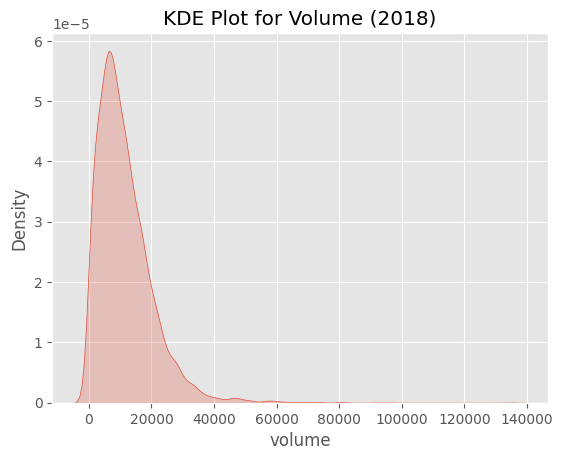

In [6]:
sns.kdeplot(df_year['volume'], shade=True).set(title='KDE Plot for Volume (2018)')

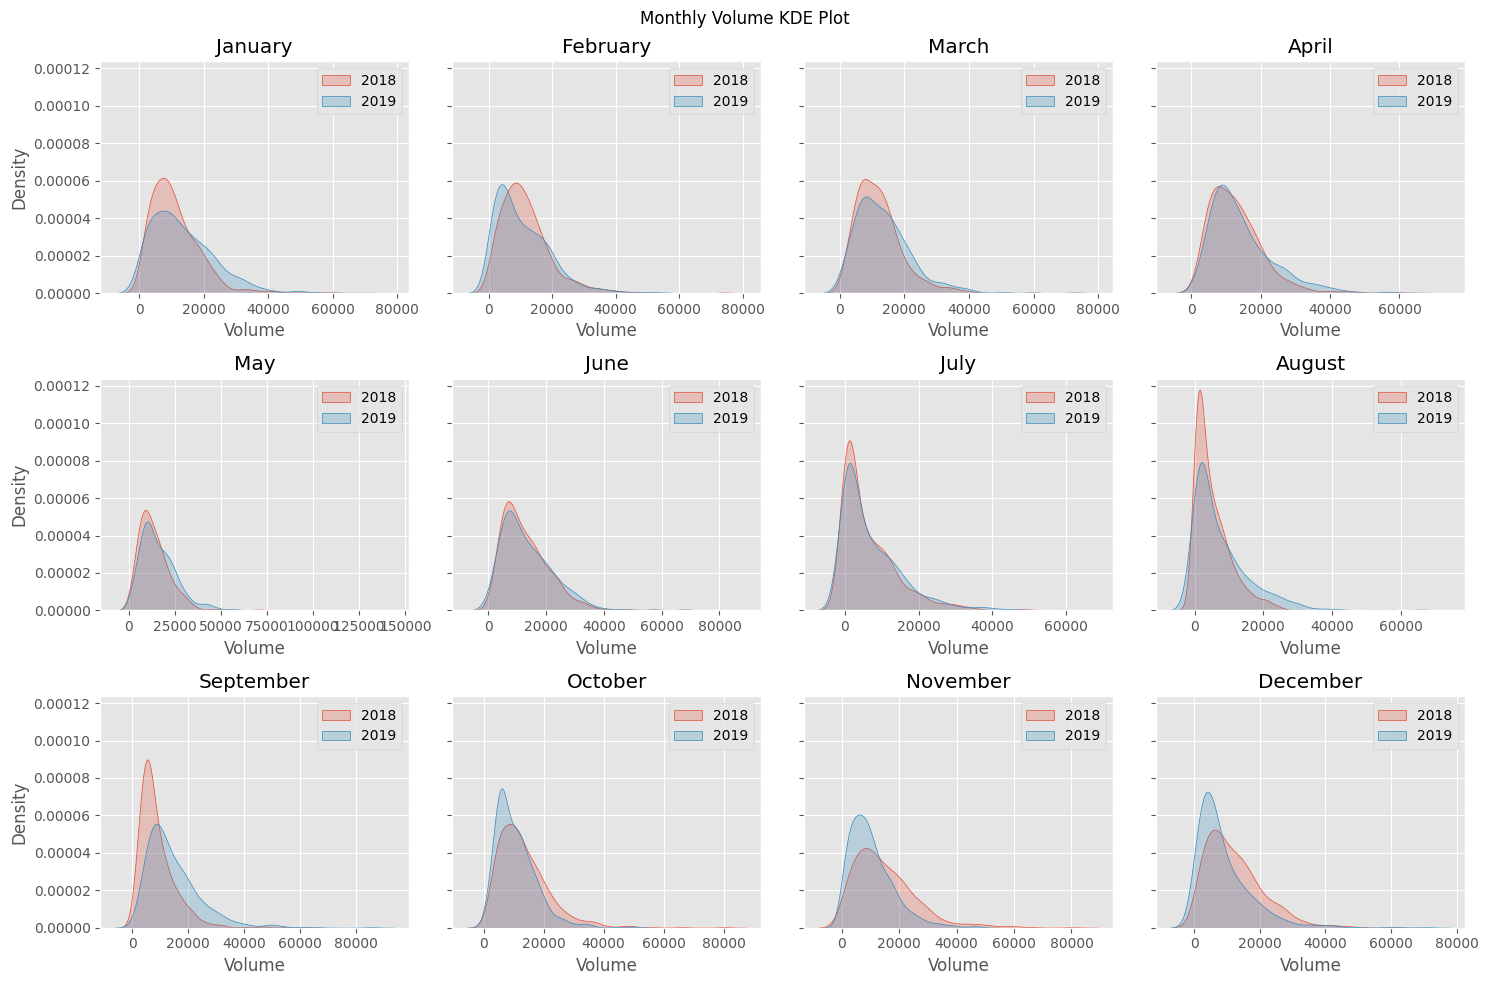

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), sharey=True)

df_year2 = df_wti[df_wti['datetime'].dt.year == 2019]
df_year3 = df_wti[df_wti['datetime'].dt.year == 2020]

for i, month in enumerate(range(1, 13)):
    ax = axes[i // 4, i % 4]
    month_data = df_year[df_year['datetime'].dt.month == month]['volume']
    sns.kdeplot(month_data, shade=True, ax=ax, label='2018')
    ax.set_title(calendar.month_name[month])
    ax.set_xlabel('Volume')
    ax.set_ylabel('Density')

    month_data = df_year2[df_year2['datetime'].dt.month == month]['volume']
    sns.kdeplot(month_data, shade=True, ax=ax, label='2019')

    month_data = df_year3[df_year3['datetime'].dt.month == month]['volume']
    # sns.kdeplot(month_data, shade=True, ax=ax, label='2020')

    ax.legend()

plt.suptitle('Monthly Volume KDE Plot')
plt.tight_layout()
plt.show()

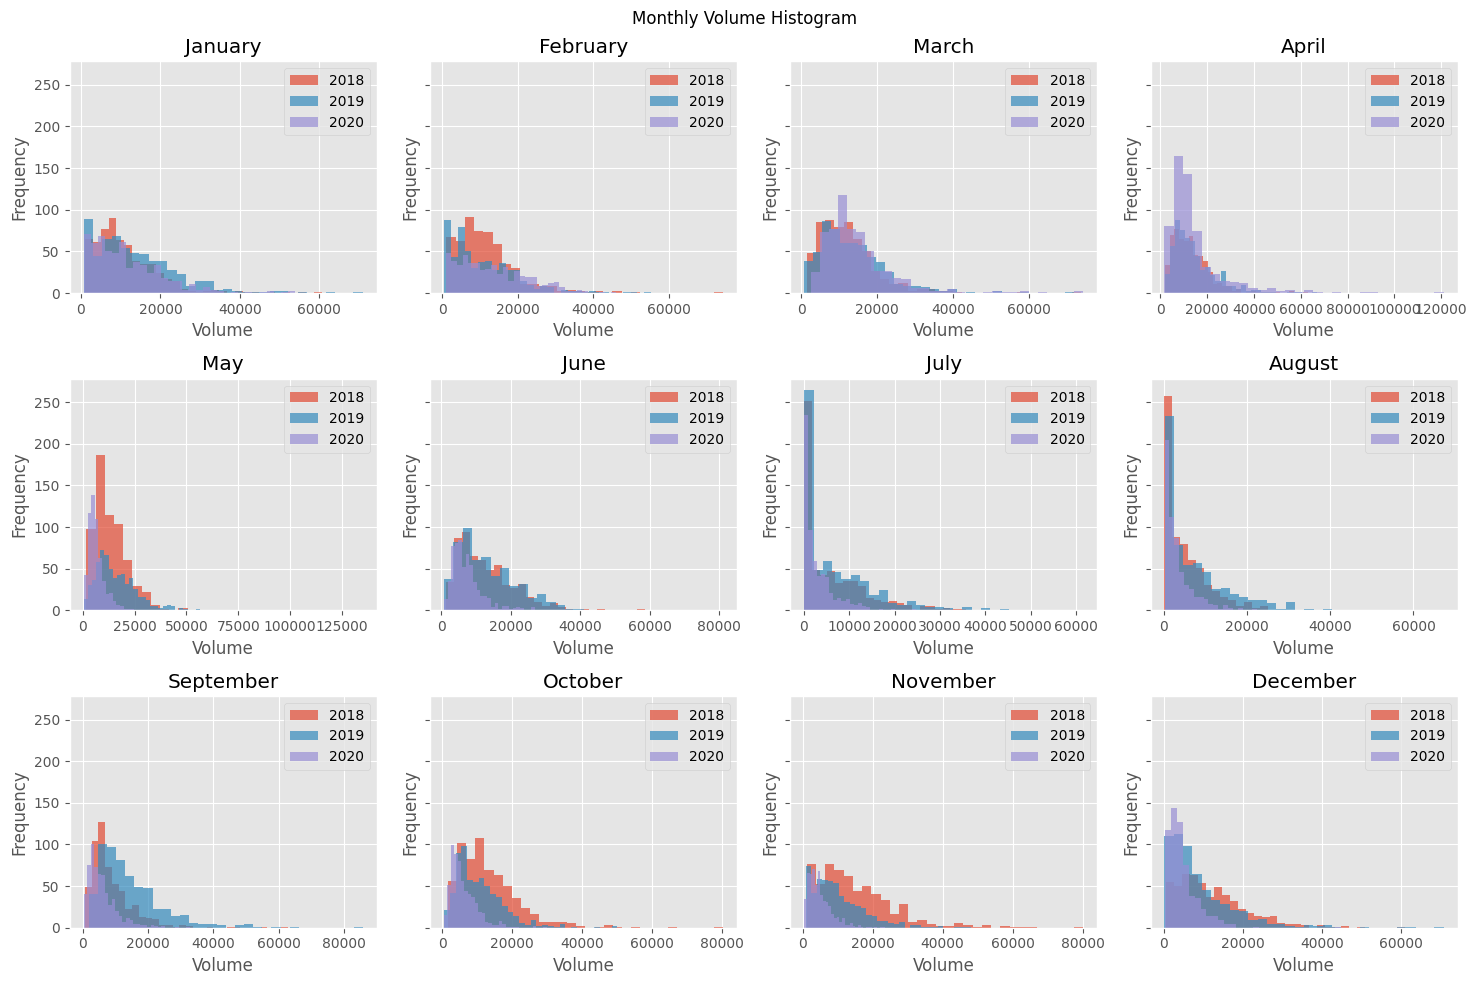

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), sharey=True)

df_year2 = df_wti[df_wti['datetime'].dt.year == 2019]
df_year3 = df_wti[df_wti['datetime'].dt.year == 2020]

for i, month in enumerate(range(1, 13)):
    ax = axes[i // 4, i % 4]
    month_data = df_year[df_year['datetime'].dt.month == month]['volume']
    ax.set_title(calendar.month_name[month])
    ax.set_xlabel('Volume')
    ax.set_ylabel('Frequency')
    month_data.hist(ax=ax, alpha=0.7, label='2018', bins=30)

    month_data = df_year2[df_year2['datetime'].dt.month == month]['volume']
    month_data.hist(ax=ax, alpha=0.7, label='2019', bins=30)

    month_data = df_year3[df_year3['datetime'].dt.month == month]['volume']
    month_data.hist(ax=ax, alpha=0.7, label='2020', bins=30)

    ax.legend()

plt.suptitle('Monthly Volume Histogram')
plt.tight_layout()
plt.show()

- Steady increase of trading volume over the years.
- Highest: January / February, Lowest: July / August
- Unimodal plot, centered around 10000
- Plot is skewed to right, there are few days with very high trading volume, possibility of extreme trading volume event

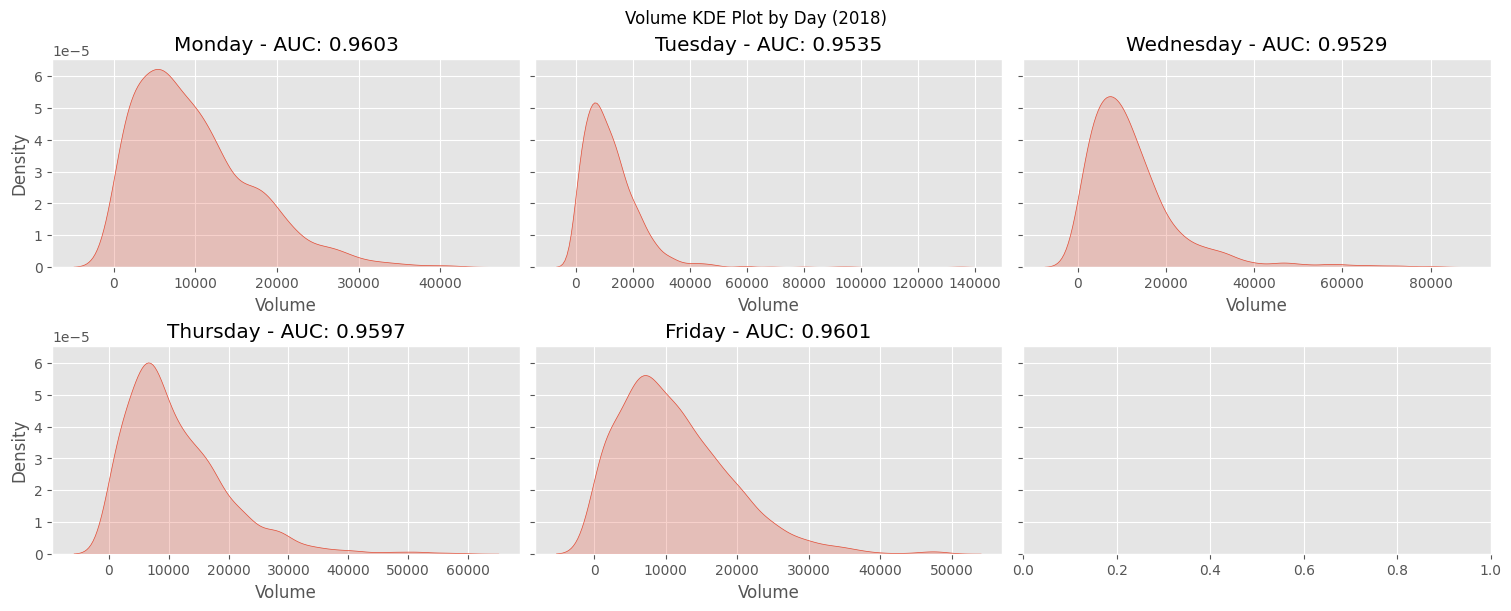

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), constrained_layout=True, sharey=True)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
for i, day in enumerate(weekdays):
    day_data = df_year[df_year['datetime'].dt.day_name() == day]
    ax = axs[i // 3, i % 3]
    ax = sns.kdeplot(data=day_data['volume'], ax=ax, shade=True)
    kde = gaussian_kde(day_data['volume'])
    auc, _ = quad(kde.pdf, min(day_data['volume']), max(day_data['volume']))

    ax.set_title(f'{day} - AUC: {auc:.4f}')
    ax.set_xlabel('Volume')
    ax.set_ylabel('Density')

plt.suptitle('Volume KDE Plot by Day (2018)')
plt.show()

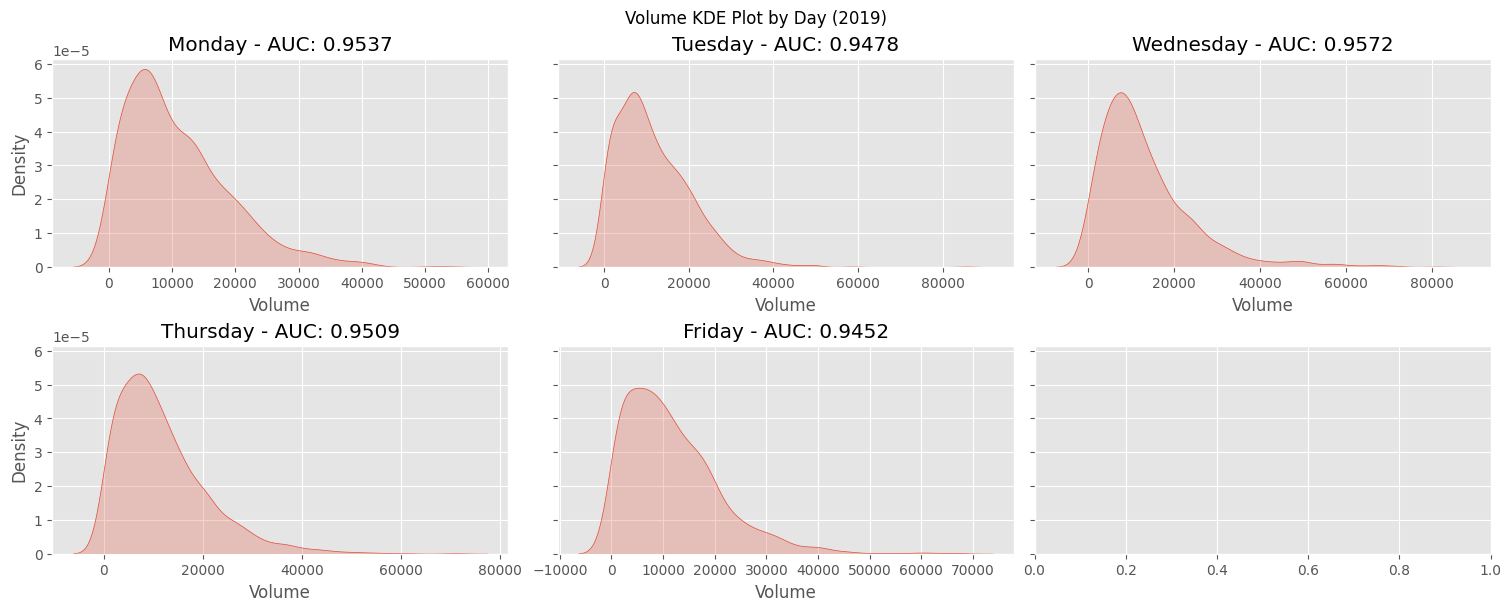

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), constrained_layout=True, sharey=True)
df_year2 = df_wti[df_wti['datetime'].dt.year == 2019]
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
for i, day in enumerate(weekdays):
    day_data = df_year2[df_year2['datetime'].dt.day_name() == day]
    ax = axs[i // 3, i % 3]
    ax = sns.kdeplot(data=day_data['volume'], ax=ax, shade=True)
    kde = gaussian_kde(day_data['volume'])
    auc, _ = quad(kde.pdf, min(day_data['volume']), max(day_data['volume']))

    ax.set_title(f'{day} - AUC: {auc:.4f}')
    ax.set_xlabel('Volume')
    ax.set_ylabel('Density')
plt.suptitle('Volume KDE Plot by Day (2019)')
plt.show()

From the volume KDE plots of 2018 and 2019, there are no significant patterns that suggest that Wednesday's volume has more fluctuations.

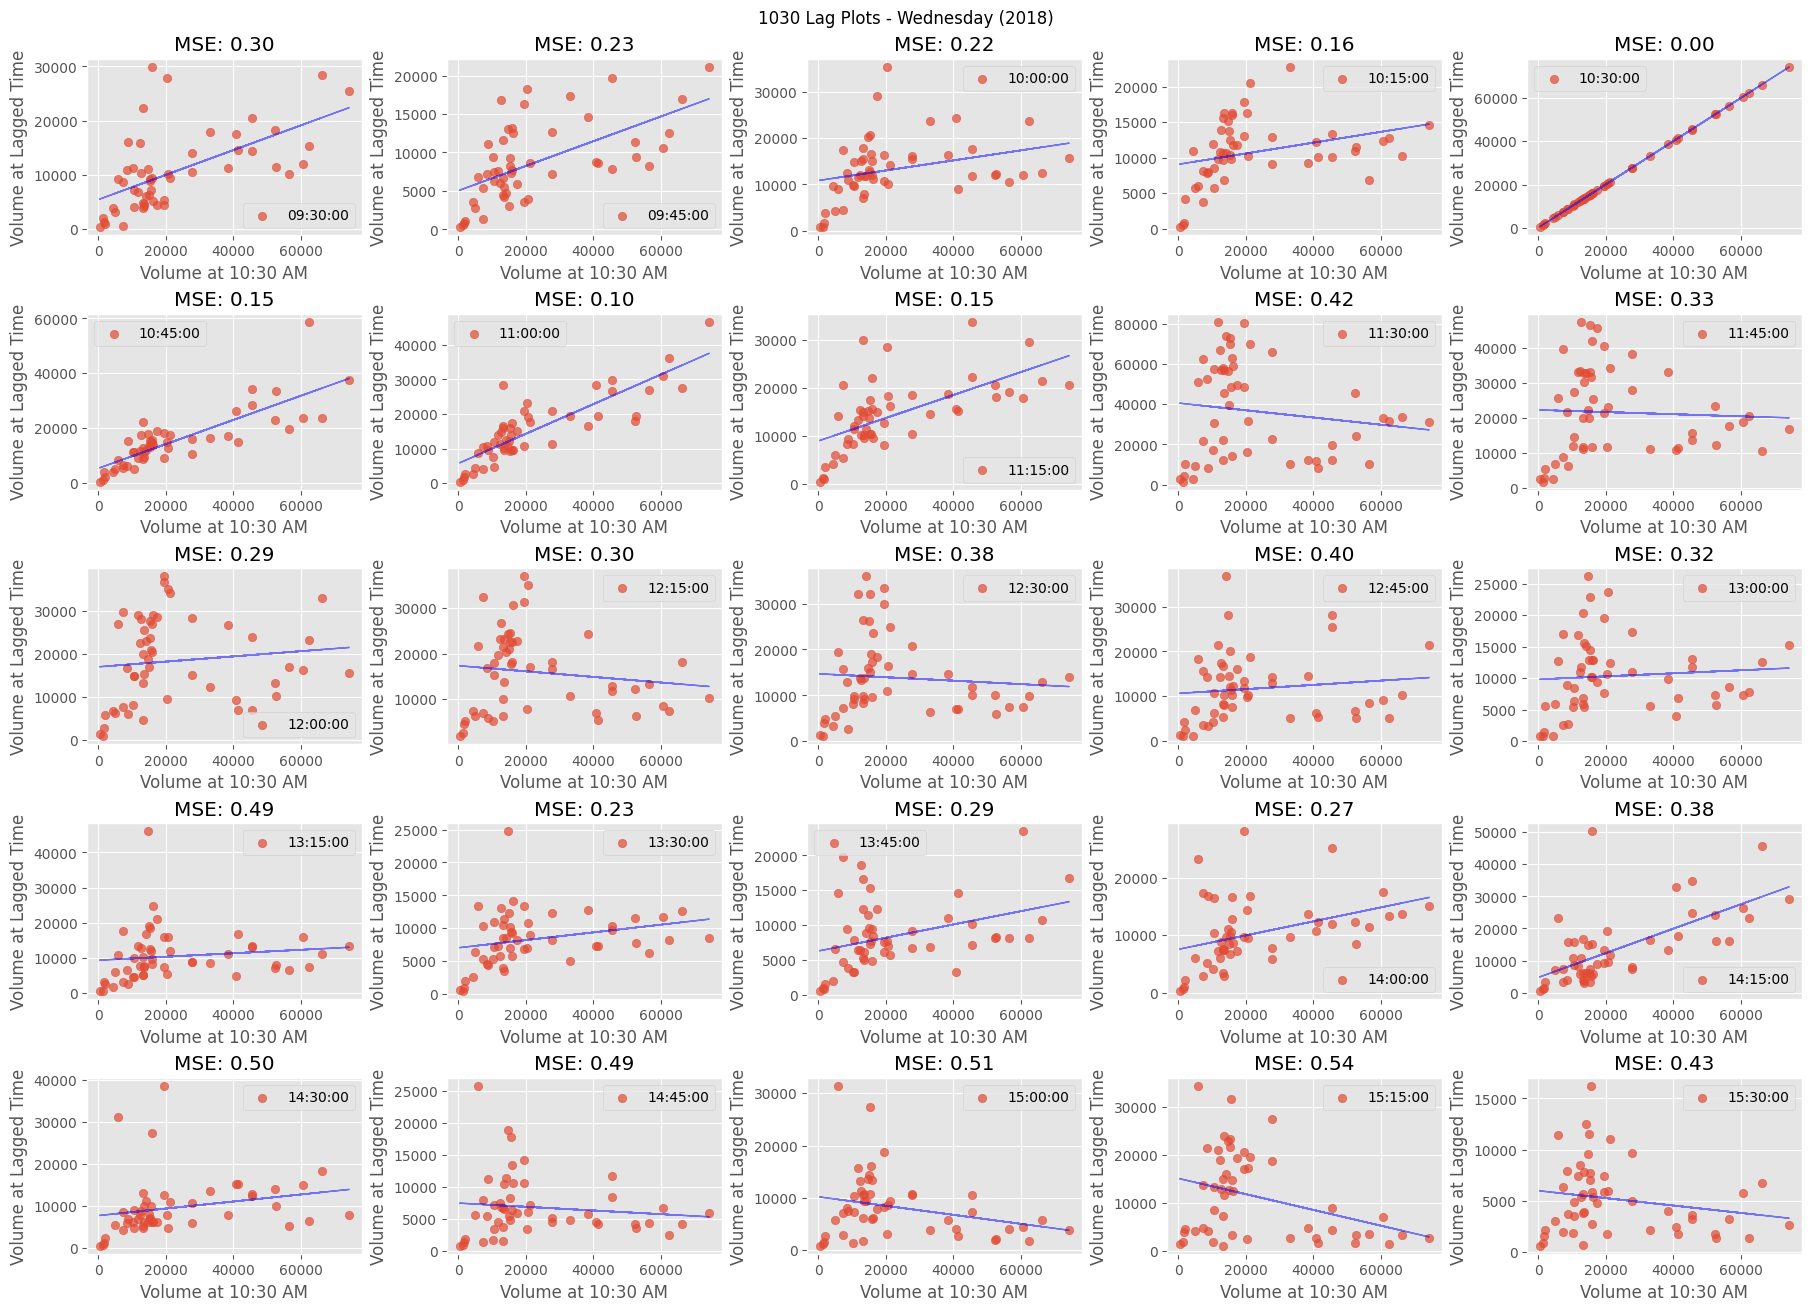

In [11]:
df_wednesday = df_year[df_year['datetime'].dt.day_name() == 'Wednesday']
df_1030 = df_wednesday[df_wednesday['datetime'].dt.time == pd.to_datetime('10:30:00').time()]

# Filter data for volumes at other specific times until 4 PM
start_time = time(9, 30)
end_time = time(15, 30)

time_points = []

# Create time points at 15-minute intervals from start to end
current_time = datetime.combine(date.today(), start_time)
while current_time.time() <= end_time:
    time_points.append(current_time.time().strftime('%H:%M:%S'))
    current_time += timedelta(minutes=15)

lag_data = []
for time_point in time_points:
    df_at_time = df_wednesday[df_wednesday['datetime'].dt.time == pd.to_datetime(time_point).time()]
    lag_data.append(df_at_time)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(18, 13), constrained_layout=True)
for i, df_lagged in enumerate(lag_data):
    ax = axs[i // 5, i % 5]

    volume_1030 = df_1030[df_1030['datetime'].dt.date.isin(df_lagged['datetime'].dt.date)]['volume']
    ax.scatter(volume_1030, df_lagged['volume'], alpha=0.7, label=f'{time_points[i]}')

    model = LinearRegression()
    X = np.array(volume_1030).reshape(-1, 1)
    y = np.array(df_lagged['volume'])
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred) / (np.mean(y)**2) 
    ax.plot(X, y_pred, color='blue', linewidth=1, alpha=0.5)

    ax.set_title(f'MSE: {mse:.2f}')
    ax.set_xlabel('Volume at 10:30 AM')
    ax.set_ylabel('Volume at Lagged Time')
    ax.legend()

plt.suptitle('1030 Lag Plots - Wednesday (2018)')
plt.show()

Trading volume seems to follow 1030 for an hour

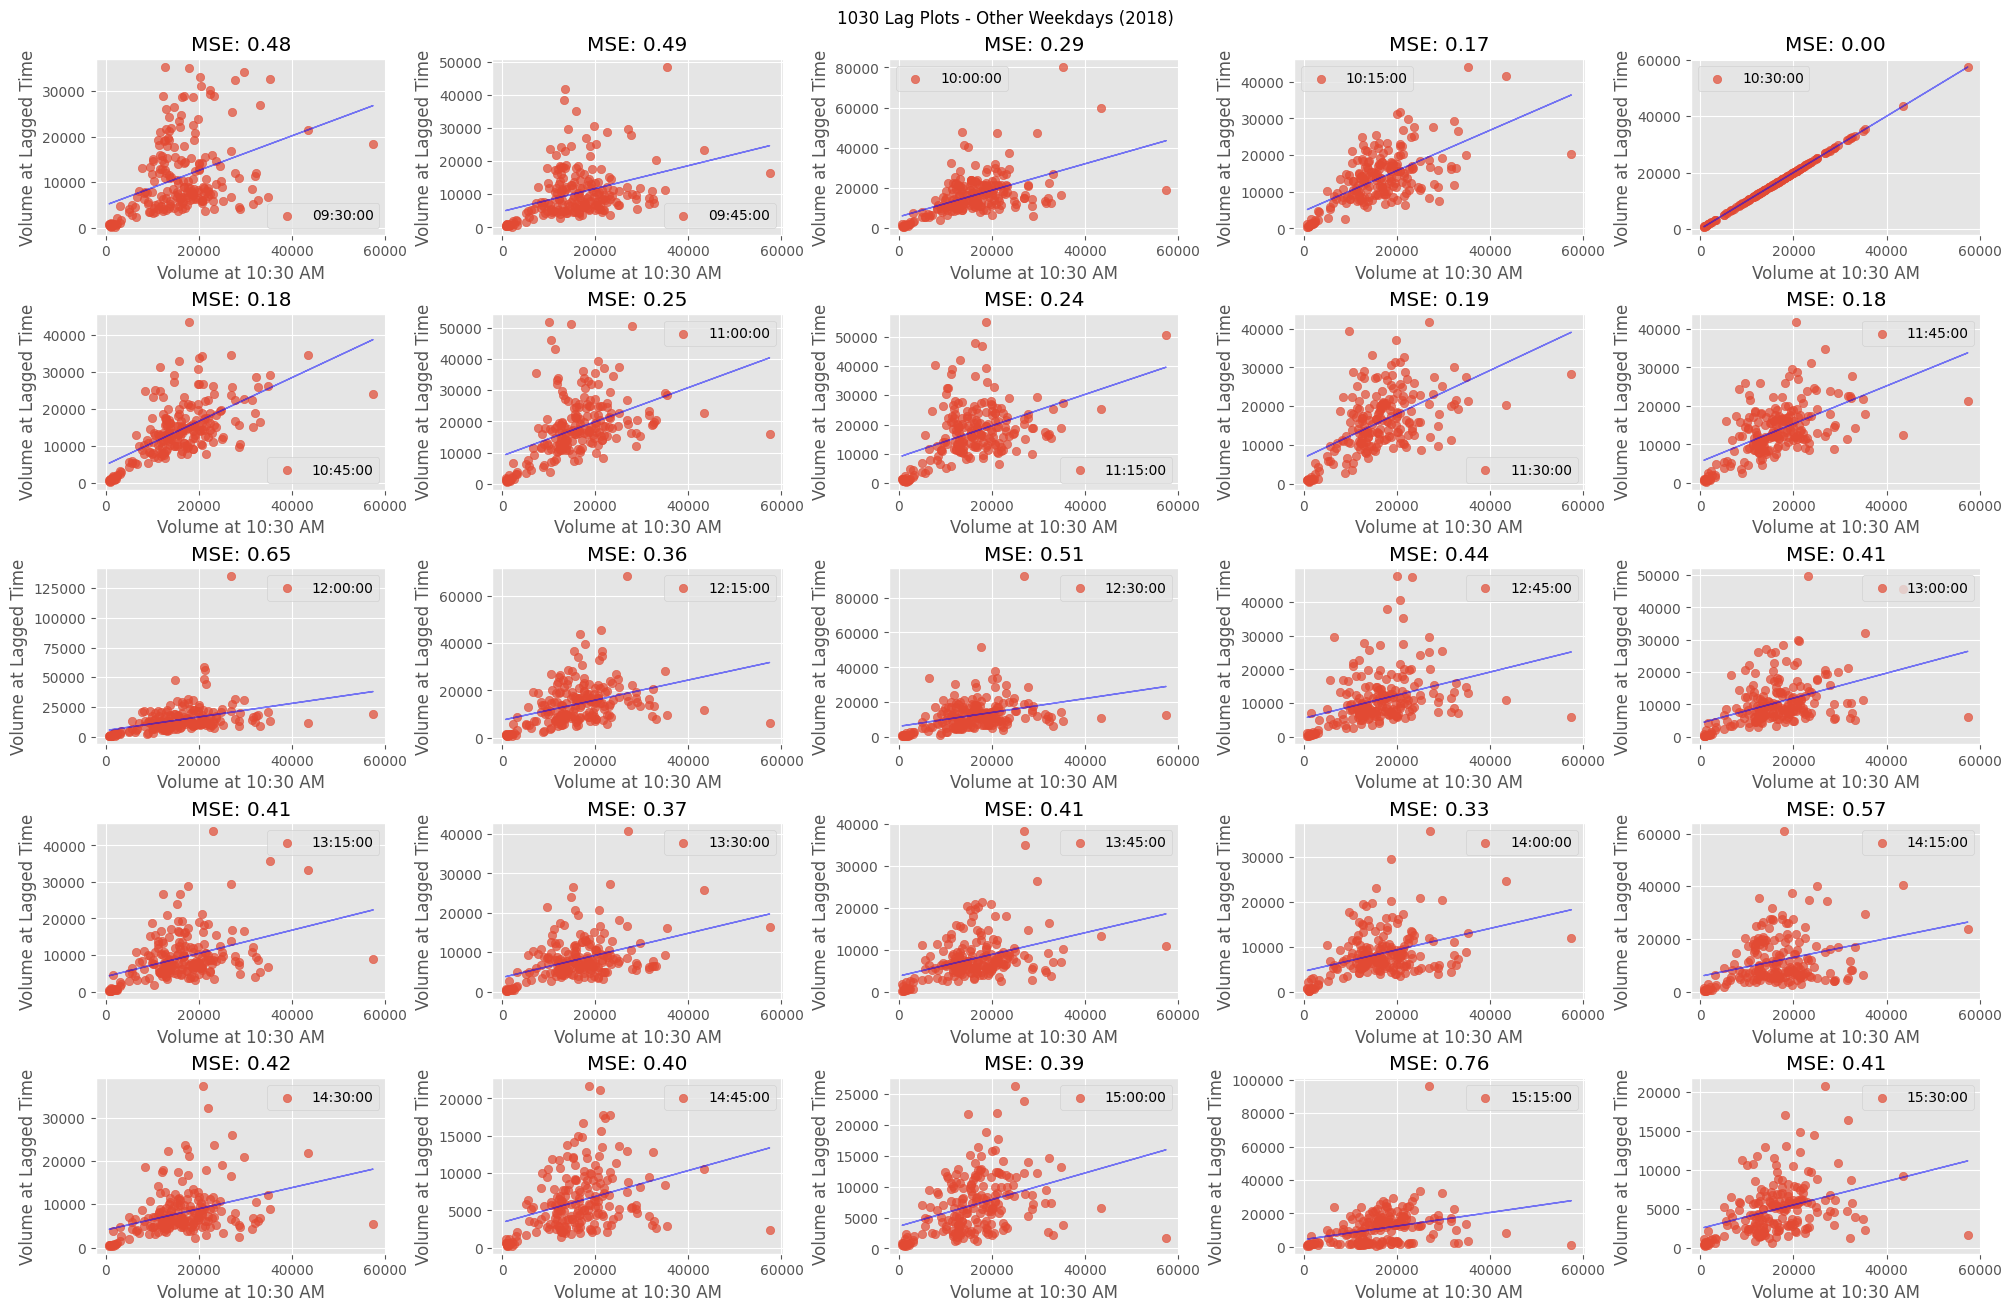

In [12]:
df_other_days = df_year[df_year['datetime'].dt.day_name() != 'Wednesday']
df_1030 = df_other_days[df_other_days['datetime'].dt.time == pd.to_datetime('10:30:00').time()]

# Filter data for volumes at other specific times until 4 PM
start_time = time(9, 30)
end_time = time(15, 30)

time_points = []

# Create time points at 15-minute intervals from start to end
current_time = datetime.combine(date.today(), start_time)
while current_time.time() <= end_time:
    time_points.append(current_time.time().strftime('%H:%M:%S'))
    current_time += timedelta(minutes=15)

lag_data = []
for time_point in time_points:
    df_at_time = df_other_days[df_other_days['datetime'].dt.time == pd.to_datetime(time_point).time()]
    lag_data.append(df_at_time)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 13), constrained_layout=True)
for i, df_lagged in enumerate(lag_data):
    ax = axs[i // 5, i % 5]

    volume_1030 = df_1030[df_1030['datetime'].dt.date.isin(df_lagged['datetime'].dt.date)]['volume']
    ax.scatter(volume_1030, df_lagged['volume'], alpha=0.7, label=f'{time_points[i]}')

    model = LinearRegression()
    X = np.array(volume_1030).reshape(-1, 1)
    y = np.array(df_lagged['volume'])
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred) / (np.mean(y)**2) 
    ax.plot(X, y_pred, color='blue', linewidth=1, alpha=0.5)

    ax.set_title(f'MSE: {mse:.2f}')

    ax.set_xlabel('Volume at 10:30 AM')
    ax.set_ylabel('Volume at Lagged Time')
    ax.legend()

plt.suptitle('1030 Lag Plots - Other Weekdays (2018)')
plt.show()

50% of volume falls within 5219.0 and 15597.0


/tmp/ipykernel_605963/757224779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Z_score'] = (df_year['volume'] - mean) / std_dev
/tmp/ipykernel_605963/757224779.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, 'weekday'] = outliers['datetime'].dt.day_name().values


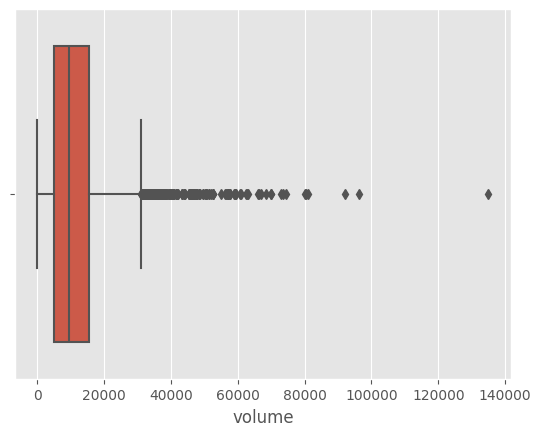

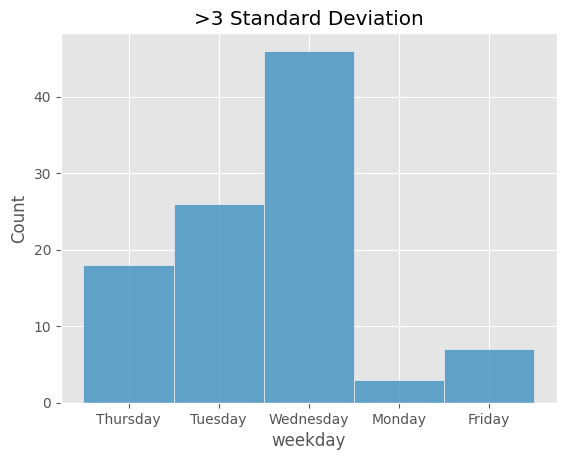

In [13]:
mean = df_year['volume'].mean()
std_dev = df_year['volume'].std()
df_year['Z_score'] = (df_year['volume'] - mean) / std_dev

threshold = 3
outliers = df_year[df_year['Z_score'] > threshold]
outliers.loc[:, 'weekday'] = outliers['datetime'].dt.day_name().values

Q1 = df_year['volume'].quantile(0.25)
Q3 = df_year['volume'].quantile(0.75)
print(f'50% of volume falls within {Q1} and {Q3}')

sns.boxplot(x=df_year['volume'])
plt.show()

sns.histplot(outliers['weekday']).set(title=f'>{threshold} Standard Deviation')
plt.show()

"Anomalous trading volume" occur more on Wednesday

# Slight problem with volume data in July / August

# 

/tmp/ipykernel_605963/2675911637.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tmp = df_year.resample('H', on='datetime').mean()


[Text(0.5, 1.0, '2018 Volume (average by hour)')]

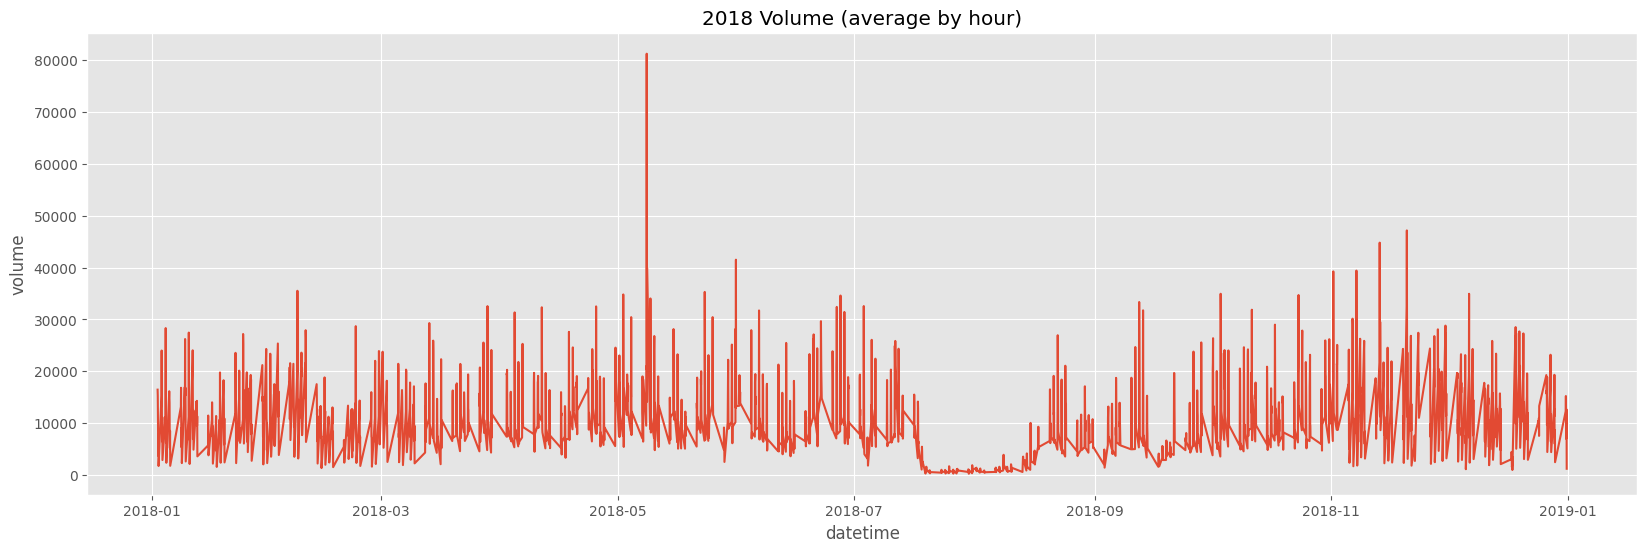

In [14]:
df_tmp = df_year.resample('H', on='datetime').mean()
df_tmp = df_tmp.dropna(axis=0).sort_values('datetime')

fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(data=df_tmp, y='volume', x='datetime', ax=ax).set(title='2018 Volume (average by hour)')

/tmp/ipykernel_605963/2132241813.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tmp = df_year2.resample('H', on='datetime').mean()


[Text(0.5, 1.0, '2017 Volume (average by hour)')]

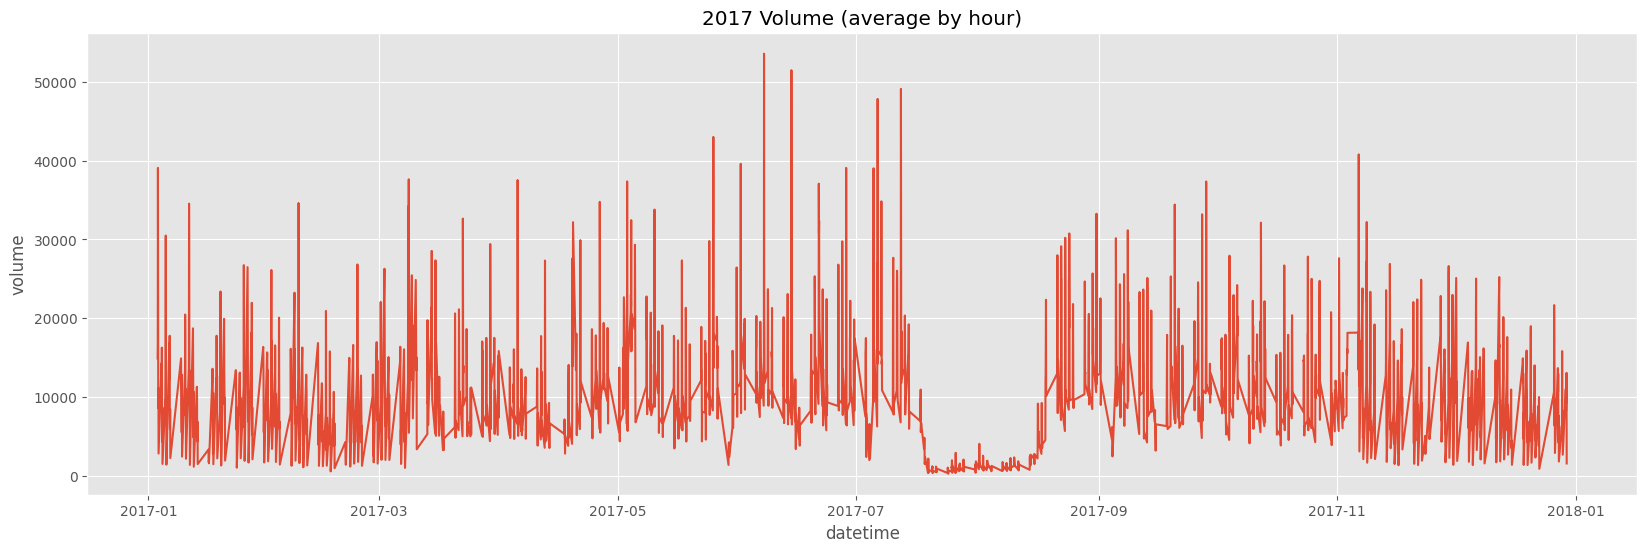

In [15]:
df_year2 = df_wti[df_wti['datetime'].dt.year == 2017]
df_tmp = df_year2.resample('H', on='datetime').mean()
df_tmp = df_tmp.dropna(axis=0).sort_values('datetime')

fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(data=df_tmp, y='volume', x='datetime', ax=ax).set(title='2017 Volume (average by hour)')

[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_605963/1824473681.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wti_day = df_year.resample('D', on='datetime').sum()


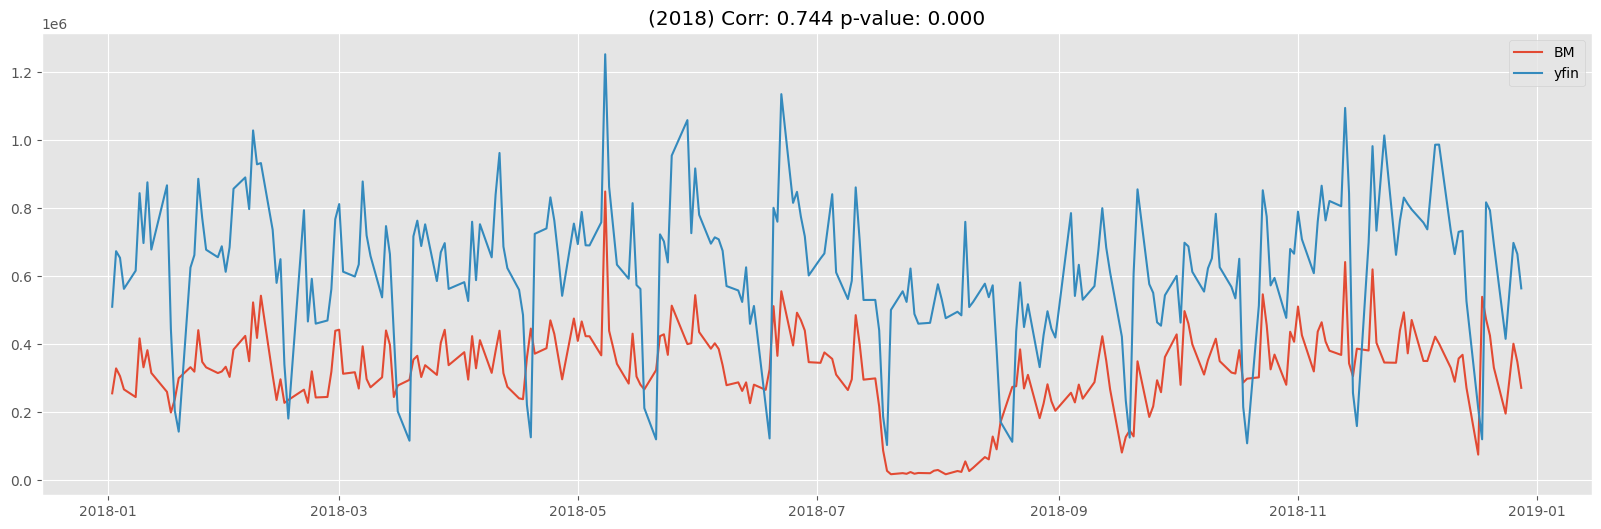

In [16]:
df_yfin = yf.download('CL=F', interval='1d', start='2018-01-01', end='2018-12-31')
df_yfin['Date'] = df_yfin.index

df_wti_day = df_year.resample('D', on='datetime').sum()
df_wti_day = df_wti_day.dropna(axis=0).sort_values('datetime')
df_wti_day = df_wti_day.reset_index(drop=False)
df_wti_day['datetime2'] = df_wti_day['datetime'].dt.strftime('%Y%m%d')
df_yfin['Date'] = df_yfin['Date'].dt.strftime('%Y%m%d')
df_wti_day = df_wti_day[df_wti_day['datetime2'].isin(df_yfin['Date'])]

corr, p_value = spearmanr(df_wti_day['volume'], df_yfin['Volume'])

plt.figure(figsize=(20, 6))
plt.plot(df_wti_day['datetime'], df_wti_day['volume'], label='BM')
plt.plot(df_wti_day['datetime'], df_yfin['Volume'], label='yfin')
plt.title(f'(2018) Corr: {corr:.3f} p-value: {p_value:.3f}')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed

/tmp/ipykernel_605963/2264916793.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wti_day = df_year.resample('D', on='datetime').sum()


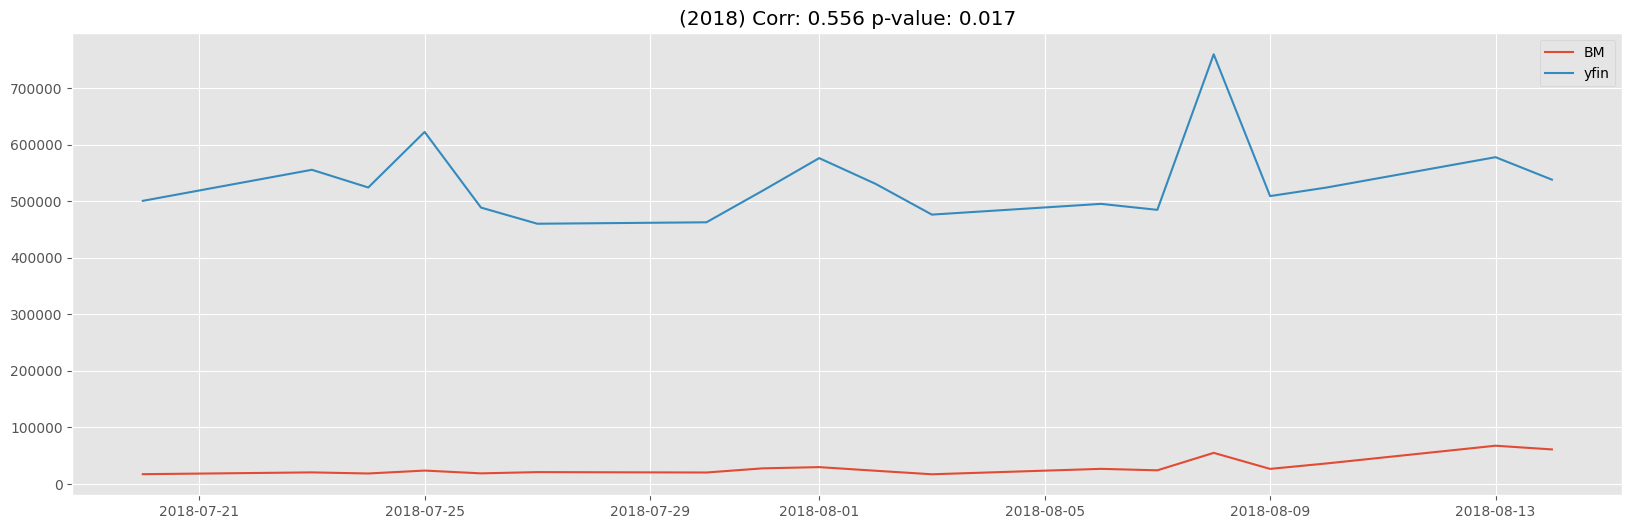

In [17]:
df_yfin = yf.download('CL=F', interval='1d', start='2018-07-20', end='2018-8-15')
df_yfin['Date'] = df_yfin.index

df_wti_day = df_year.resample('D', on='datetime').sum()
df_wti_day = df_wti_day.dropna(axis=0).sort_values('datetime')
df_wti_day = df_wti_day.reset_index(drop=False)
# df_wti_day = df_wti_day[(df_wti_day['datetime'].dt.month == 7) | (df_wti_day['datetime'].dt.month == 8)]
df_wti_day['datetime2'] = df_wti_day['datetime'].dt.strftime('%Y%m%d')
df_yfin['Date'] = df_yfin['Date'].dt.strftime('%Y%m%d')
df_wti_day = df_wti_day[df_wti_day['datetime2'].isin(df_yfin['Date'])]

corr, p_value = spearmanr(df_wti_day['volume'], df_yfin['Volume'])

plt.figure(figsize=(20, 6))
plt.plot(df_wti_day['datetime'], df_wti_day['volume'], label='BM')
plt.plot(df_wti_day['datetime'], df_yfin['Volume'], label='yfin')
plt.title(f'(2018) Corr: {corr:.3f} p-value: {p_value:.3f}')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_605963/3821387324.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wti_day = df_tmp.resample('D', on='datetime').sum()


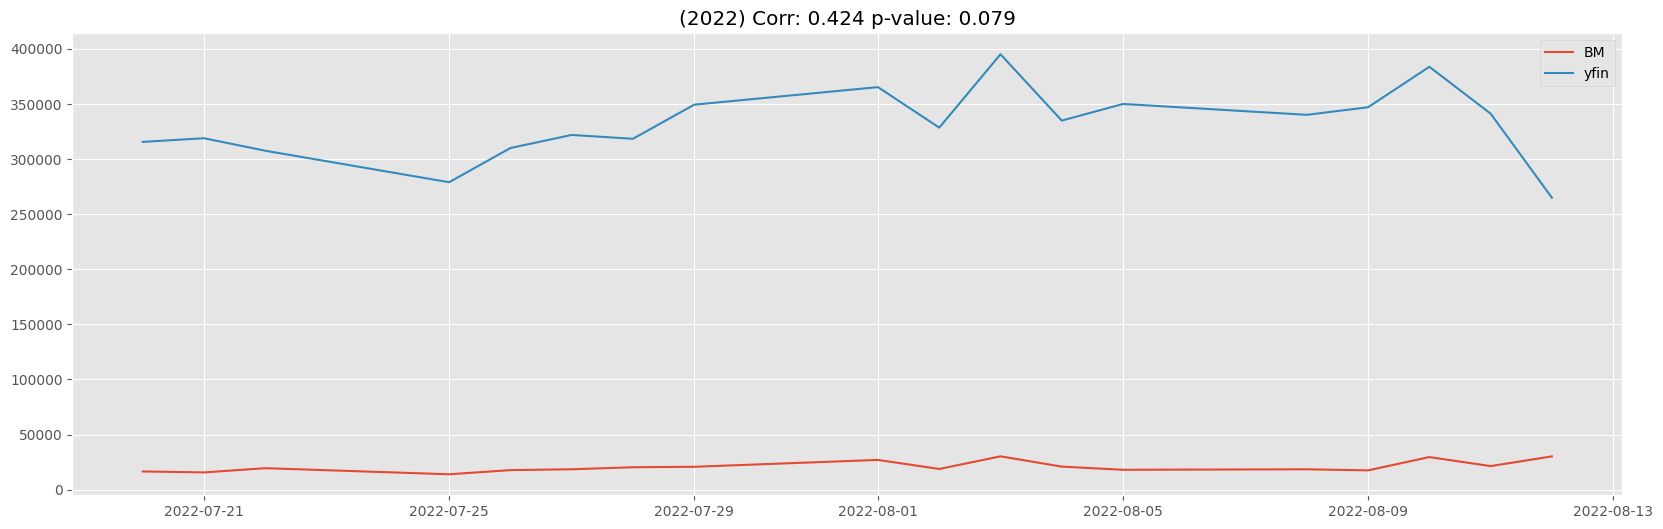

In [18]:
df_yfin = yf.download('CL=F', interval='1d', start='2022-07-20', end='2022-8-15')
df_yfin['Date'] = df_yfin.index

df_tmp = df_wti[df_wti['datetime'].dt.year == 2022]
df_wti_day = df_tmp.resample('D', on='datetime').sum()
df_wti_day = df_wti_day.dropna(axis=0).sort_values('datetime')
df_wti_day = df_wti_day.reset_index(drop=False)
df_wti_day['datetime2'] = df_wti_day['datetime'].dt.strftime('%Y%m%d')
df_yfin['Date'] = df_yfin['Date'].dt.strftime('%Y%m%d')
df_wti_day = df_wti_day[df_wti_day['datetime2'].isin(df_yfin['Date'])]

corr, p_value = spearmanr(df_wti_day['volume'], df_yfin['Volume'])

plt.figure(figsize=(20, 6))
plt.plot(df_wti_day['datetime'], df_wti_day['volume'], label='BM')
plt.plot(df_wti_day['datetime'], df_yfin['Volume'], label='yfin')
plt.title(f'(2022) Corr: {corr:.3f} p-value: {p_value:.3f}')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed

/tmp/ipykernel_605963/682029082.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wti_day = df_tmp.resample('D', on='datetime').mean()


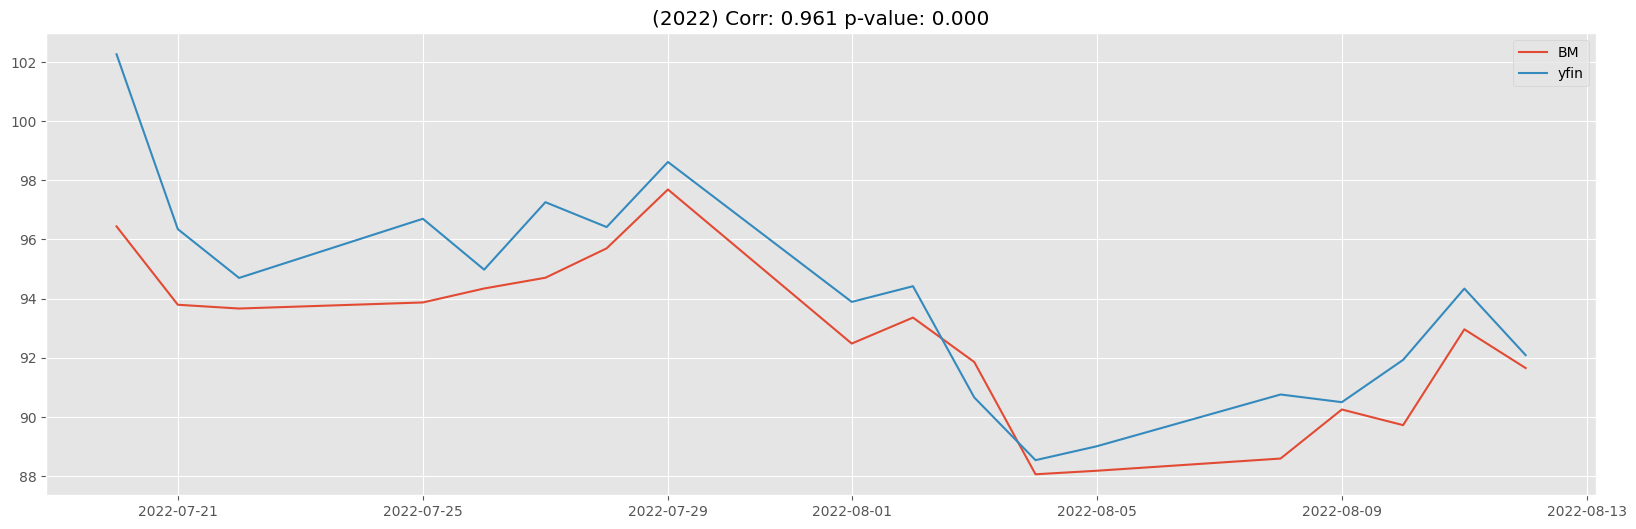

In [19]:
df_yfin = yf.download('CL=F', interval='1d', start='2022-07-20', end='2022-8-15')
df_yfin['Date'] = df_yfin.index

df_tmp = df_wti[df_wti['datetime'].dt.year == 2022]
df_wti_day = df_tmp.resample('D', on='datetime').mean()
df_wti_day = df_wti_day.dropna(axis=0).sort_values('datetime')
df_wti_day = df_wti_day.reset_index(drop=False)
df_wti_day['datetime2'] = df_wti_day['datetime'].dt.strftime('%Y%m%d')
df_yfin['Date'] = df_yfin['Date'].dt.strftime('%Y%m%d')
df_wti_day = df_wti_day[df_wti_day['datetime2'].isin(df_yfin['Date'])]

corr, p_value = spearmanr(df_wti_day['close'], df_yfin['Close'])

plt.figure(figsize=(20, 6))
plt.plot(df_wti_day['datetime'], df_wti_day['close'], label='BM')
plt.plot(df_wti_day['datetime'], df_yfin['Close'], label='yfin')
plt.title(f'(2022) Corr: {corr:.3f} p-value: {p_value:.3f}')
plt.legend()
plt.show()

# Simple Moving Average

- Run a simple moving average over volume with a window size of 4 (average by hour)
- Check for SMA values that are 2 standard deviations larger

In [35]:
window = 4
df_year['sma'] = df_year['volume'].rolling(window=window).mean()

threshold = df_year['sma'].std() * 2
anomalous_times = df_year[df_year['volume'] > (df_year['sma'] + threshold)]
anomalous_days = anomalous_times['datetime'].dt.date.unique()

np.random.shuffle(anomalous_days)
for day in anomalous_days[:5]:
    df_day = df_year[df_year['datetime'].dt.date == day]
    anomal_time = df_day[df_day['volume'] > (df_day['sma'] + threshold)]
    idx = anomal_time.index.values

    plot_candlestick(
        df_day,
        idx,
        f'{day}: {day.strftime("%A")}'
    )

/tmp/ipykernel_605963/3708490319.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
anomalous_times[anomalous_times['day'] == 'Wednesday']

1130    24
1030    12
1415     4
1000     1
1145     1
Name: time, dtype: int64

In [ ]:
anomalous_times[anomalous_times['day'] != 'Wednesday']['time'].value_counts().head()

1000    13
0900    12
1100    11
1415    10
1115     8
Name: time, dtype: int64